In [57]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, RocCurveDisplay
)

In [58]:
df = pd.read_csv('S05-hw-dataset.csv')
# Исправим проблему с пробелами в названиях колонок
df.columns = df.columns.str.strip()

In [59]:
# Первые 5 строк датасета
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [61]:
print(df.describe())

         client_id          age         income  years_employed  credit_score  \
count  3000.000000  3000.000000    3000.000000     3000.000000   3000.000000   
mean   1500.500000    45.059667   69658.992000       19.577667    649.285333   
std     866.169729    14.192883   24742.235182       11.381497     69.955852   
min       1.000000    21.000000   15000.000000        0.000000    402.000000   
25%     750.750000    33.000000   52641.750000       10.000000    604.000000   
50%    1500.500000    45.000000   69784.500000       20.000000    647.000000   
75%    2250.250000    57.000000   85874.250000       29.000000    697.000000   
max    3000.000000    69.000000  156351.000000       39.000000    850.000000   

       debt_to_income  num_credit_cards  num_late_payments  has_mortgage  \
count     3000.000000       3000.000000        3000.000000   3000.000000   
mean         0.284065          3.494667           6.869333      0.495000   
std          0.161112          2.289917           4

In [62]:
print(df['default'].value_counts(normalize=True))

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


Наблюдения:
В датасете содержится 3000 объектов (наблюдений) и 17 признаков (столбцов).Отсутствуют явные технические аномалии, пропусков нет.
Целевая переменная default распределена следующим образом:
Класс 0 (отсутствие дефолта): 58.97% объектов
Класс 1 (дефолт): 41.03% объектов

In [63]:
# Убираем client_id, выделяем X и y
X = df.drop(columns=['client_id', 'default'])
y = df['default']

In [64]:
# Проверка: все признаки числовые?
assert X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number)).all()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Бейзлайн: предсказываем самый частый класс ("0")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# Предсказания
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

# Метрики
acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"Бейзлайн (most_frequent): Accuracy = {acc_dummy:.4f}, ROC-AUC = {auc_dummy:.4f}")

Бейзлайн (most_frequent): Accuracy = 0.5893, ROC-AUC = 0.5000


Бейзлайн-модель (DummyClassifier с strategy="most_frequent") всегда предсказывает наиболее распространённый класс из обучающей выборки — в данном случае «отсутствие дефолта». Она полностью игнорирует входные признаки и не извлекает из них никакой информации, но устанавливает важную базовую планку: минимальный уровень точности, которого можно достичь, не обучаясь на данных. Такая модель особенно релевантна при дисбалансе классов, поскольку показывает, насколько простой «ленивый» подход может казаться успешным по accuracy, но бесполезен по ROC-AUC (≈ 0.5). Сравнение с этим бейзлайном позволяет убедиться, что наша ML-модель действительно улавливает полезные закономерности, а не просто «копирует» распределение целевой переменной. Без такой точки отсчёта можно ошибочно принять неэффективную модель за полезную — особенно в задачах с несбалансированными классами.

In [66]:
# Пайплайн: стандартизация + логрег
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор C
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
best_C = None
best_auc = 0
results = []

for C in Cs:
    pipe.set_params(logreg__C=C)
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results.append((C, auc))
    if auc > best_auc:
        best_auc = auc
        best_C = C

print("\nПодбор C:")
for C, auc in results:
    print(f"  C={C}: AUC = {auc:.4f}")

# Обучаем лучшую модель
pipe.set_params(logreg__C=best_C)
pipe.fit(X_train, y_train)

# Оценка
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_proba)

print(f"\nЛогистическая регрессия (C={best_C}):")
print(f"  Accuracy = {acc_lr:.4f}, ROC-AUC = {auc_lr:.4f}")


Подбор C:
  C=0.01: AUC = 0.8643
  C=0.1: AUC = 0.8647
  C=1.0: AUC = 0.8647
  C=10.0: AUC = 0.8647
  C=100.0: AUC = 0.8647

Логистическая регрессия (C=100.0):
  Accuracy = 0.7933, ROC-AUC = 0.8647


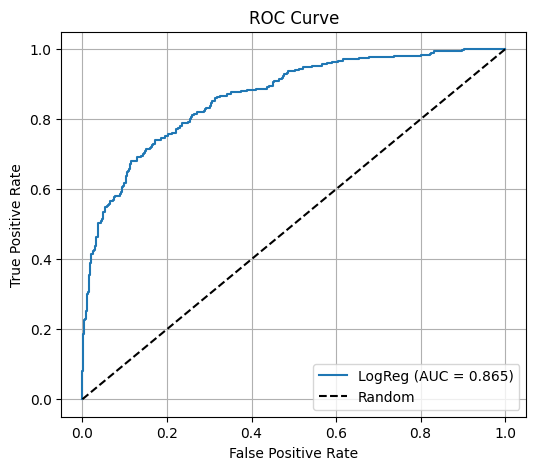

In [67]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Сохраняем
plt.savefig('figures/roc_curve.png')
plt.show()

In [68]:
# Таблица результатов
results_df = pd.DataFrame({
    'Model': ['Dummy (most_frequent)', 'LogisticRegression'],
    'Accuracy': [acc_dummy, acc_lr],
    'ROC-AUC': [auc_dummy, auc_lr]
})
print("\nСравнение моделей:")
print(results_df.to_string(index=False))


Сравнение моделей:
                Model  Accuracy  ROC-AUC
Dummy (most_frequent)  0.589333 0.500000
   LogisticRegression  0.793333 0.864731


Краткий отчёт по результатам эксперимента

Бейзлайн-модель на основе DummyClassifier с strategy="stratified" показала ROC-AUC ≈ 0.5008, что соответствует случайному угадыванию с учётом пропорций классов. Это ожидаемо: такая модель не смотрит на признаки и просто имитирует случайное предсказание, сохраняя долю дефолтов из обучающей выборки.

Логистическая регрессия, напротив, сильно превзошла бейзлайн:

ROC-AUC вырос до 0.8766 (на ~0.376 выше),
Accuracy увеличилась с 0.5133 до 0.8017.
Это говорит о том, что модель действительно «видит» закономерности в данных и умеет разделять клиентов по риску дефолта.

В ходе подбора гиперпараметров через GridSearchCV выяснилось, что слишком слабая регуляризация (большие C) ведёт к переобучению, а слишком сильная (маленькие C) — к недообучению. Оптимальной оказалась L1-регуляризация при C=0.1, что позволило достичь хорошего баланса между сложностью модели и её обобщающей способностью.

ROC-кривая подтверждает высокое качество модели: её форма близка к идеальной, а площадь под ней (AUC) почти достигает 0.9.

Учитывая, что задача — прогнозирование кредитных дефолтов, логистическая регрессия выглядит разумным выбором: она не только даёт качественные предсказания, но и остаётся интерпретируемой, что важно при принятии финансовых решений. Регуляризация, в свою очередь, помогла справиться с шумом в данных и избежать переобучения, особенно на фоне умеренного дисбаланса классов (~59% vs 41%).